# Training GAT on Full Data

This notebook trains and evaluates the GAT AE on the full dataset.

In [18]:
import torch
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
from warnings import filterwarnings
filterwarnings('ignore')

from models import GATAE
from parameters import GATAEParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_gatae, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc, discrete_fp_delays_loc
import torch.nn as nn
from tqdm import tqdm

import random
import os
import torch_geometric
seed=42
torch_geometric.seed_everything(seed)

### Time Series Sequencing

In [19]:
def sequence_gatae(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy()) # assumes time indices come sequentially, with full data it may not

        node_data = np.concatenate(data_t[::-1])
        pyg_data = Data(x=torch.tensor(node_data, dtype=torch.float32), edge_index=relational_edges, edge_attr=torch.tensor(relations, dtype=torch.long))
        
        # curr_data = data_t[-1]
        curr_data = data_t[0]
        
        curr_graph = Data(x=torch.tensor(curr_data, dtype=torch.float32), edge_index=static_edges)
        sequence.append([pyg_data, curr_graph])

    return sequence, kept_indices

### Loading Hyperparameters

In [20]:
hide_anomalies = False
optimal_hyperparams = load_best_parameters('gat', hide_anomalies)

In [21]:
mse_weights = [1,1,1] # weights for loss function (occupancy, speed, volume)

In [22]:
training_params = TrainingParameters(
    learning_rate=optimal_hyperparams['learning_rate'],
    batch_size=1,
    timesteps=optimal_hyperparams['timesteps'],
    n_epochs=optimal_hyperparams['epochs']
)

In [23]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_gatae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_gatae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)

100%|██████████| 2871/2871 [00:20<00:00, 143.05it/s]


In [24]:
hyperparams = GATAEParameters(
    num_features=3,
    latent_dim=optimal_hyperparams['latent_dim'],
    gcn_hidden_dim=optimal_hyperparams['gcn_hidden_dim'],
    dropout=optimal_hyperparams['dropout'],
    num_layers=optimal_hyperparams['num_layers'],
    num_heads=optimal_hyperparams['num_heads']
)

In [25]:
# ae = GATAE(hyperparams)

### Model Training or Loading

In [26]:
using_pretrained = True

In [27]:
if not using_pretrained:
    ae, losses = train_gatae(gataeparams=hyperparams, trainingparams=training_params, training_data=train_sequence, mse_weights=mse_weights, verbose=True)
    save_model(ae, f'gat_{hide_anomalies}_{seed}')
else:
    ae = load_model(GATAE, hyperparams, f'gat_{hide_anomalies}_{seed}')

In [28]:
if not using_pretrained:
    plt.plot(losses)

### Computing Node-level Anomaly Threshold

In [29]:
thresh = compute_anomaly_threshold_rstae(val_sequence, ae, mse_weights, 'max')

100%|██████████| 2847/2847 [00:09<00:00, 291.55it/s]


### Loading Test Data

In [30]:
_, df_test_data, _ = get_full_data()

In [31]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gatae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4791/4791 [00:40<00:00, 118.63it/s]


In [32]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [33]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
# crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

In [34]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]
results=discrete_fp_delays_loc(thresh, test_errors, anomaly_labels, crash_reported)



100%|██████████| 1000/1000 [00:28<00:00, 34.53it/s]

Found FPR of 0.01 for 0.01
Found FPR of 0.025 for 0.025
Found FPR of 0.050416666666666665 for 0.05
Found FPR of 0.09875 for 0.1
Found FPR of 0.19958333333333333 for 0.2
FPR 1% gives mean delay of -4.666666666666667 +/- 8.532617157446802 with mean. distance of 3.344444444444444 +/- 3.700784034381877 while missing 0.4%.
FPR 2.5% gives mean delay of -8.928571428571429 +/- 7.480587120906312 with mean. distance of 3.1149999999999998 +/- 3.85461087530246 while missing 0.30000000000000004%.
FPR 5% gives mean delay of -10.5 +/- 6.819090848492928 with mean. distance of 3.36 +/- 3.0640496079535002 while missing 0.30000000000000004%.
FPR 10% gives mean delay of -12.11111111111111 +/- 4.445833116387234 with mean. distance of 3.392307692307692 +/- 2.290519436708806 while missing 0.09999999999999998%.
FPR 20% gives mean delay of -13.1 +/- 1.8814887722226779 with mean. distance of 2.84375 +/- 2.366951824076696 while missing 0.0%.


In [17]:
path_results = 'saved_results/gat/'
results = discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

# Check if the directory exists, and create it if it does not
if not os.path.exists(path_results):
    os.makedirs(path_results)

# Save the results to a CSV file
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

  0%|          | 4/1000 [00:00<00:29, 33.26it/s]

100%|██████████| 1000/1000 [00:29<00:00, 34.24it/s]

Found FPR of 0.009876543209876543 for 0.01
Found FPR of 0.025102880658436213 for 0.025
Found FPR of 0.050205761316872426 for 0.05
Found FPR of 0.1 for 0.1
Found FPR of 0.20041152263374484 for 0.2
FPR 1% gives mean delay of 1.8571428571428572 +/- 8.534444017853627 while missing 0.41666666666666663%.
FPR 2.5% gives mean delay of -2.1666666666666665 +/- 7.434902674398487 while missing 0.25%.
FPR 5% gives mean delay of -8.222222222222221 +/- 5.652487707545291 while missing 0.25%.
FPR 10% gives mean delay of -12.166666666666666 +/- 3.5433819375782165 while missing 0.25%.
FPR 20% gives mean delay of -13.7 +/- 1.977371993328519 while missing 0.16666666666666663%.


In [18]:
calculate_auc(test_errors, anomaly_labels)

0.6909287202154143

### Compute FPR / Crash Detection Delay Tradeoff

In [21]:
delay_results = np.array(find_delays(thresh, test_errors, anomaly_labels, crash_reported))

100%|██████████| 98/98 [00:00<00:00, 228.32it/s]


In [22]:
delay_df = pd.DataFrame(delay_results, columns=['FPR', 'Mean Delay', 'Std Delay', 'Found Percent'])
delay_df.to_csv('./saved_results/gatae_fp_delay.csv')

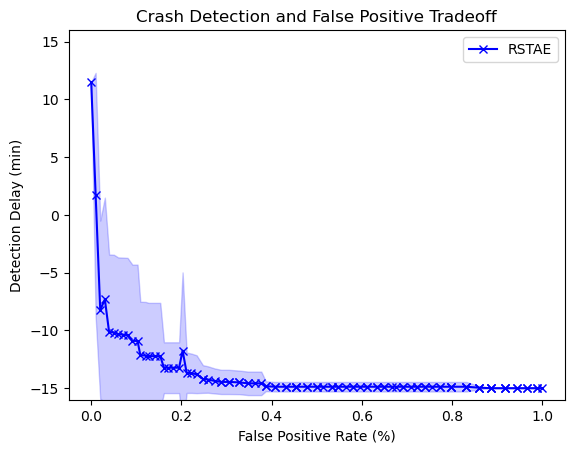

In [23]:
x_values = delay_df['FPR']
y_values = delay_df['Mean Delay'] / 2
std_values = delay_df['Std Delay'] / 2

plt.plot(x_values, y_values, color='blue', label='RSTAE', marker='x')

lower_bound = y_values - std_values  # 1.96 is the z-score for 95% confidence interval
upper_bound = y_values + std_values

plt.fill_between(x_values, lower_bound, upper_bound, color='blue', alpha=0.2)
plt.ylim(-16, 16)
# plt.xlim(-0.01,1)
plt.xlabel("False Positive Rate (%)")
plt.ylabel("Detection Delay (min)")
plt.title("Crash Detection and False Positive Tradeoff")
plt.legend()
plt.show()

In [24]:
discrete_fp_delays(thresh, test_errors, anomaly_labels, crash_reported)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:29<00:00, 33.89it/s]

Found FPR of 0.009828009828009828 for 0.01
Found FPR of 0.025389025389025387 for 0.025
Found FPR of 0.049959049959049956 for 0.05
Found FPR of 0.09828009828009827 for 0.1
Found FPR of 0.20270270270270271 for 0.2
FPR 1% gives mean delay of 1.75 +/- 10.547511554864494 while missing 0.33333333333333337%.
FPR 2.5% gives mean delay of -7.318181818181818 +/- 8.814432192491644 while missing 0.08333333333333337%.
FPR 5% gives mean delay of -10.181818181818182 +/- 6.732798713194736 while missing 0.08333333333333337%.
FPR 10% gives mean delay of -10.909090909090908 +/- 6.605157013542805 while missing 0.08333333333333337%.
FPR 20% gives mean delay of -11.75 +/- 6.771570472694401 while missing 0.0%.


### Compute AUC

In [18]:
calculate_auc(test_errors, anomaly_labels)

0.6893512167860592

### Compute Detection Delay Histogram on Full Dataset

In [26]:
_, _, full_data = get_full_data()
full_data = normalize_data(full_data)
full_data = label_anomalies(full_data)

In [27]:
full_sequence, kept_full_indices = sequence_gatae(full_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 23/18238 [00:00<01:21, 222.66it/s]

100%|██████████| 18238/18238 [01:23<00:00, 219.21it/s]


In [28]:
full_errors, _, _ = test_rstae(full_sequence, mse_weights, ae)

In [29]:
full_anomalies = generate_anomaly_labels(full_data, kept_full_indices)
crash_reported = full_data['crash_record'].to_numpy()[0::196][kept_full_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [30]:
full_thresholds = find_thresholds(thresh, full_errors, full_anomalies)

100%|██████████| 1000/1000 [01:58<00:00,  8.45it/s]


In [31]:
offset = find_percent(full_thresholds, 10)
full_anomaly_pred = threshold_anomalies(thresh+offset, full_errors)


Found FPR of 0.09950133364258379 for 0.1


In [32]:
delay, found = crash_detection_delay(full_anomaly_pred, crash_reported)

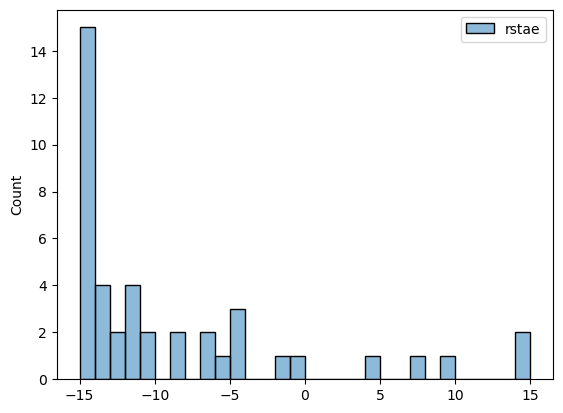

In [33]:
import seaborn as sns 

delay = delay + [30] * (len(found) - np.count_nonzero(found))

sns.histplot(np.array(delay)/2, binwidth=1, alpha=0.5, label='rstae')
plt.legend()

In [34]:
np.save('./saved_results/gatae10delays.npy', np.array(delay)/2)

In [35]:
_, df_clean_test_data, _ = get_full_data()

In [36]:
clean_test_data = normalize_data(df_clean_test_data)
clean_test_data = label_anomalies(clean_test_data)
clean_test_data, kept_test_indices = sequence_gatae(clean_test_data, training_params.timesteps, hide_anomalies=True)

  0%|          | 0/4798 [00:00<?, ?it/s]

100%|██████████| 4798/4798 [00:07<00:00, 611.45it/s]


In [37]:
clean_test_errors, test_recons_speeds, test_true_speeds = test_rstae(clean_test_data, mse_weights, ae)

In [38]:
np.mean(clean_test_errors)

0.008736244

## Case Study (Shown in Paper)

In [39]:
_, df_test_data, _ = get_full_data()

In [40]:
df_test_data = df_test_data[df_test_data['day']==10]

In [41]:
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_gatae(test_data, training_params.timesteps, hide_anomalies=False)

  0%|          | 0/958 [00:00<?, ?it/s]

100%|██████████| 958/958 [00:01<00:00, 753.28it/s]


In [42]:
test_errors, test_recons_speeds, test_true_speeds = test_rstae(test_data, mse_weights, ae)

In [43]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [44]:
anomalies_10 = threshold_anomalies(thresh+offset_10, test_errors)

In [45]:
data = fill_result_df(anomalies_10, test_true_speeds, test_recons_speeds, training_params.timesteps)

In [46]:
data.to_csv('./saved_results/anom_results_gat.csv')

In [47]:
df_test_data[df_test_data['crash_record']==1]

,day,milemarker,human_label,crash_record,unix_time,speed,occ,volume
343441,10,53.3,0,1,1697023470,63.153616,16.0,15.0
1284241,10,53.3,0,1,1697023470,61.369748,15.0,11.0
2225041,10,53.3,0,1,1697023470,58.138872,15.0,14.0
3165841,10,53.3,0,1,1697023470,56.912889,16.0,15.0
343442,10,53.6,0,1,1697023470,62.593691,13.0,14.0
...,...,...,...,...,...,...,...,...
3165888,10,69.8,0,1,1697023470,70.568478,1.0,2.0
343489,10,70.1,0,1,1697023470,77.669218,3.0,5.0
1284289,10,70.1,0,1,1697023470,73.904376,5.0,8.0
2225089,10,70.1,0,1,1697023470,71.009237,2.0,4.0


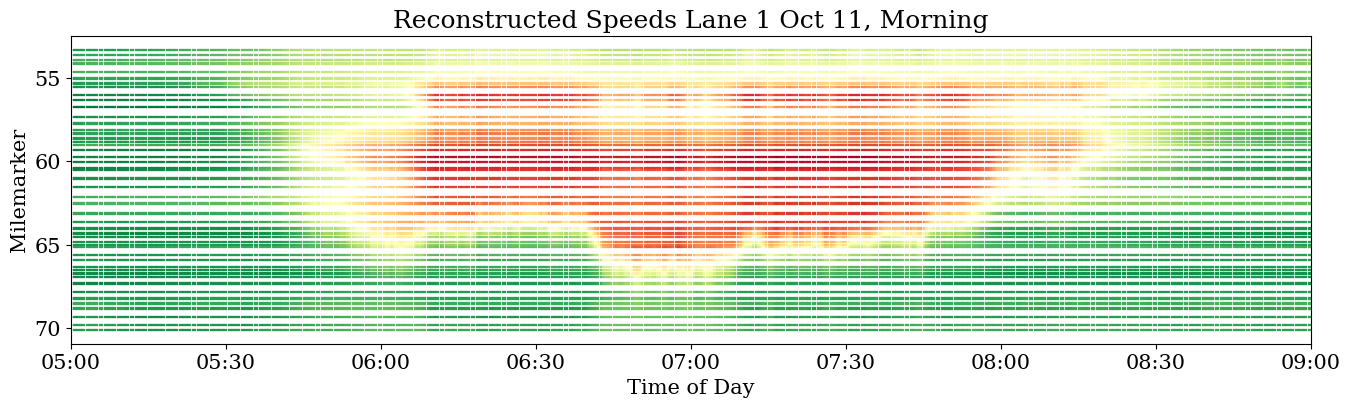

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/anom_results_gat.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index']*30+ 14400, unit='s') 
plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed'].values),marker='s',s=1, cmap='viridis')
# filtered_lane = lane[lane['Anomaly'] == 1]

# plt.scatter(filtered_lane['Time Index'], filtered_lane['Milemarker'].values,
#             c=filtered_lane['Anomaly'].values, marker='s', s=1, cmap='RdYlGn', label='Nominal', alpha=0.5)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Reconstructed Speeds Lane 1 Oct 11, Morning")
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.xlim(start_time, end_time)
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.show()

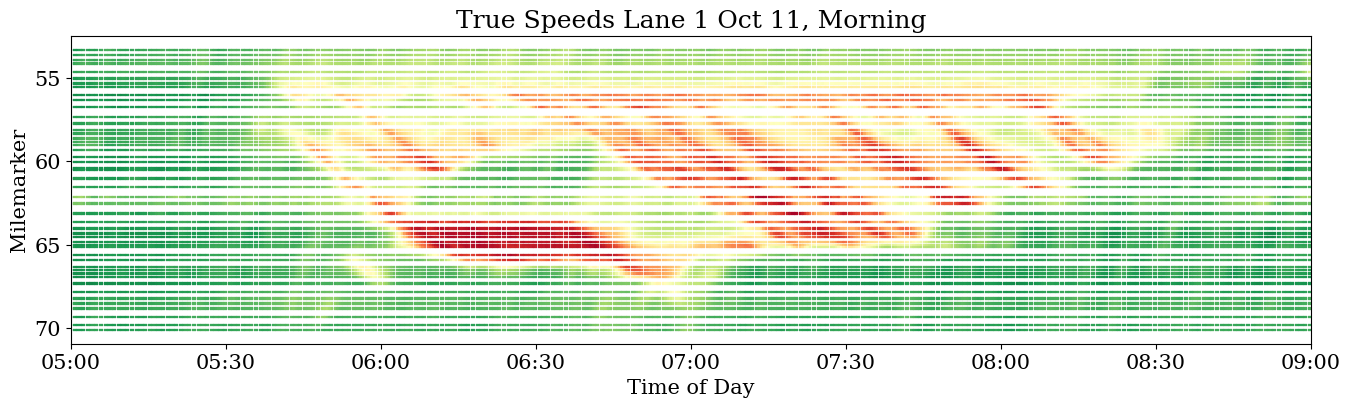

In [49]:
from matplotlib.ticker import MultipleLocator

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
plt.scatter(lane['Time Index'] , lane.Milemarker.values, 
                            c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.01))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.xlim(start_time, end_time)
# plt.ylim()

plt.title("True Speeds Lane 1 Oct 11, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
# plt.xlim(30000, 90000)

plt.show()

In [50]:
time_anomalies = np.any(anomalies_10==1, axis=1)

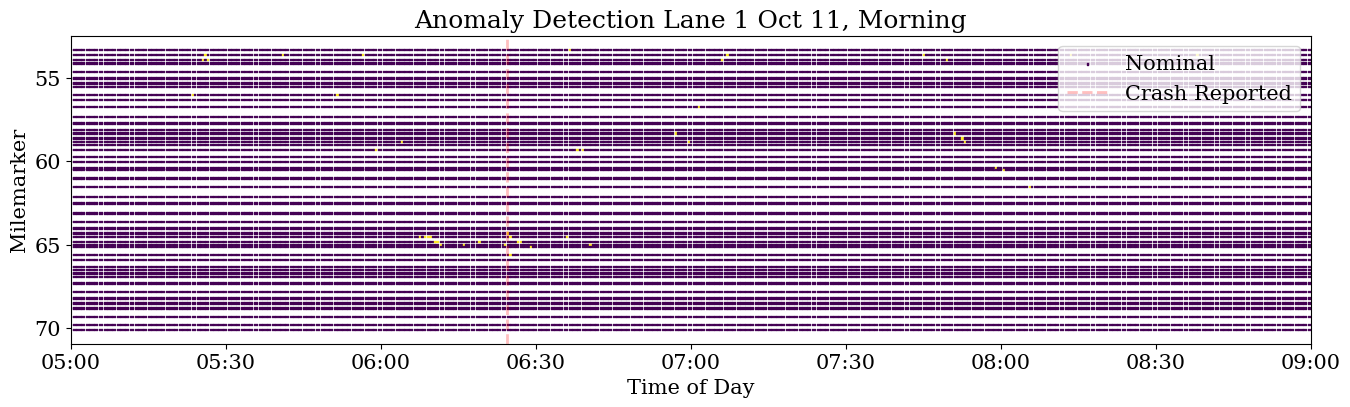

In [51]:
crash_reported = np.where(np.array(df_test_data['crash_record']==1))[0][0] / 196
crash_reported =  pd.to_datetime(crash_reported*30+ 14400, unit='s') 

plt.figure(figsize=(16,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
anomaly_times = lane.loc[lane['Anomaly'] == 1, 'Time Index'].unique()
plt.scatter(lane['Time Index'] , lane.Milemarker.values, 
                            c=lane['Anomaly'].values,marker='s',s=1, cmap='viridis', label='Nominal')
plt.gca().invert_yaxis()
# plt.gca().xaxis.set_major_locator(MultipleLocator(0.5))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
# Set x-axis limits
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.xlim(start_time, end_time)

# Add vertical line at '1970-01-01 09:39:22'
# vline_time = pd.to_datetime('1970-01-01 09:39:22')
plt.axvline(x=crash_reported, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.25)
# plt.axhline(y=62.2, color='red', linestyle='--', alpha=0.25)
# plt.ylim(60,65)

plt.legend(loc='upper right')
plt.title("Anomaly Detection Lane 1 Oct 11, Morning")
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")

plt.show()

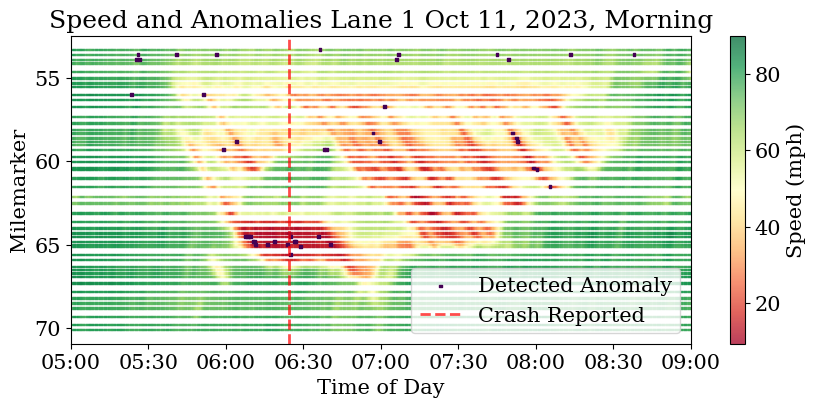

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/anom_results_gat.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index']*30+ 14400, unit='s') 
plt.figure(figsize=(10,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=np.abs(lane['Reconstructed Speed'].values-lane['Speed'].values),marker='s',s=1, cmap='viridis')
scatter = plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=lane['Speed'].values*80,marker='s',s=1, cmap='RdYlGn', alpha=0.75)
colorbar = plt.colorbar(scatter, label='Speed (mph)')
filtered_lane = lane[lane['Anomaly'] == 1]

plt.scatter(filtered_lane['Time Index'], filtered_lane['Milemarker'].values,
            c=filtered_lane['Anomaly'].values, marker='s', s=4, cmap='viridis', label='Detected Anomaly', alpha=1)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Speed and Anomalies Lane 1 Oct 11, 2023, Morning")
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.axvline(x=crash_reported, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.7)
plt.xlim(start_time, end_time)
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.legend(loc='lower right')
plt.show()

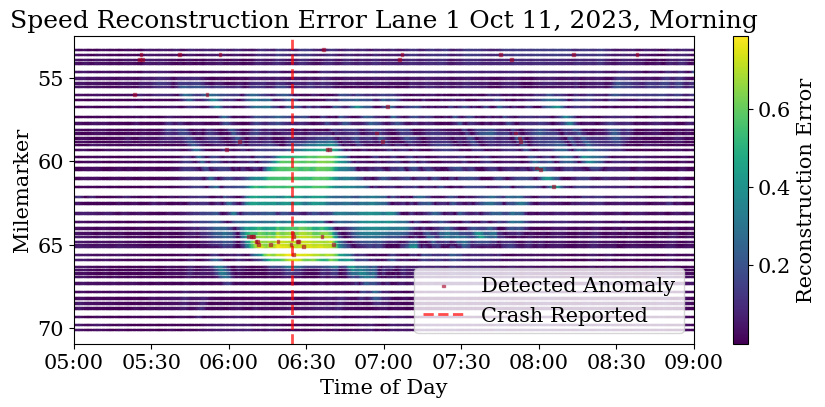

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

data = pd.read_csv('./saved_results/anom_results_gat.csv', index_col=0)
data['Time Index'] = pd.to_datetime(data['Time Index']*30+ 14400, unit='s') 
plt.figure(figsize=(10,4), facecolor='white')
plt.rc('font', family='serif', size=15)
lane = data[data.Lane == 1]
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Reconstructed Speed'].values,marker='s',s=1, cmap='RdYlGn')
scatter = plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
                            c=np.abs(lane['Reconstructed Speed'].values-lane['Speed'].values),marker='s',s=1, cmap='viridis')
colorbar = plt.colorbar(scatter, label='Reconstruction Error')
# plt.scatter(lane['Time Index'].values , lane.Milemarker.values, 
#                             c=lane['Speed'].values,marker='s',s=1, cmap='RdYlGn', alpha=0.75)
filtered_lane = lane[lane['Anomaly'] == 1]

plt.scatter(filtered_lane['Time Index'], filtered_lane['Milemarker'].values,
            c=filtered_lane['Anomaly'].values, marker='s', s=4, cmap='RdYlGn', label='Detected Anomaly', alpha=0.5)
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.title("Speed Reconstruction Error Lane 1 Oct 11, 2023, Morning")
start_time = pd.to_datetime('1970-01-01 05:00:00')
end_time = pd.to_datetime('1970-01-01 09:00:00')
plt.axvline(x=crash_reported, color='red', linestyle='--', linewidth=2, label='Crash Reported', alpha=0.7)
plt.xlim(start_time, end_time)
plt.xlabel("Time of Day")
plt.ylabel("Milemarker")
plt.legend(loc='lower right')
plt.show()